In [2]:
# This is the final which should mirror the Kaggle notebook

# Climate Change Belief Analysis
#### by Team_SS4_JHB_First_Class on {date}

# Introduction 

# Table of Contents

1. Importing Libraries
2. Importing Dataset
3. Data Preprocessing
4. Exploratory Data Analysis
5. Feature Engineering and Selection
6. Model Selection 
7. Model Evaluation
8. References

# Importing Libraries

In [3]:
# Importing modules for data science and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# NLP Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn import metrics


# Importing dataset

In [4]:
# Loading in the datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv('sample_submission.csv')

# Data Preprocessing

## Summary Statistics

In [5]:
df = train.copy()

In [6]:
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [8]:
df.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


## Missing values

## Data Exploration

In [21]:
working_df = train.copy()
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']] # Labeling the target


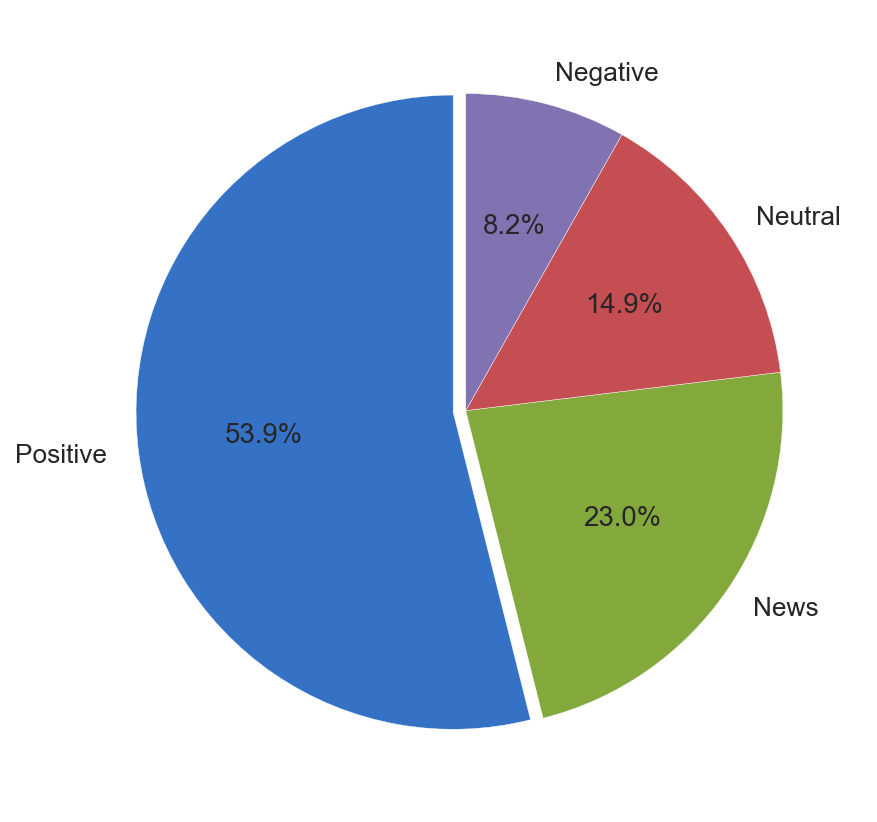

In [46]:
# checking the distribution
values = working_df['sentiment'].value_counts()/working_df.shape[0]
labels = (working_df['sentiment'].value_counts()/working_df.shape[0]).index
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0))
plt.show()

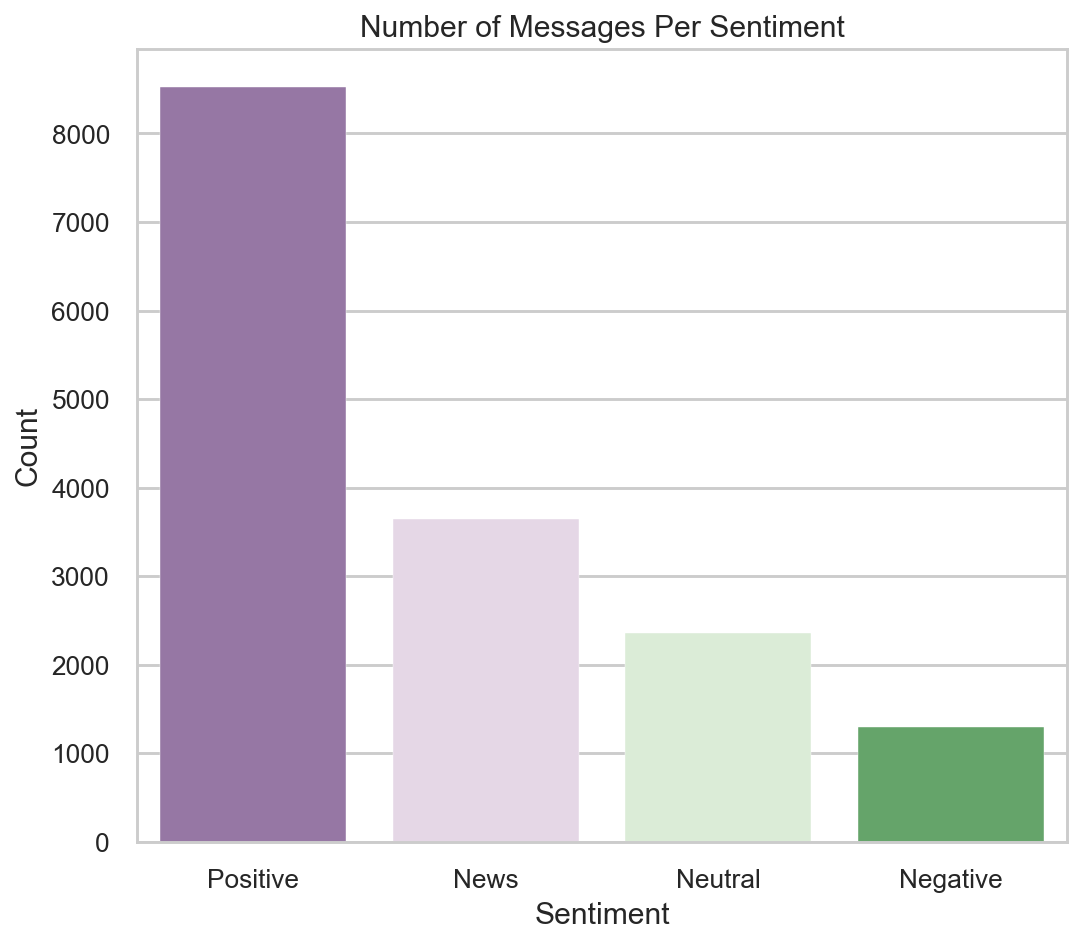

In [37]:
sns.countplot(x='sentiment' ,data = working_df, palette='PRGn')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Number of Messages Per Sentiment')
plt.show()

It is notable that there is an imbalance of classes in the daset  and these tend to be a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. This is can cause problems as most algorithms are designed to maximize accuracy and reduce error. Therefore we ill address and take care of the class imbalance in our EDA

In [39]:
# Extracting Users in a column
working_df['users'] = [''.join(re.findall(r'@\w{,}', line)) if '@' in line else np.nan for line in working_df.message]

In [40]:
# Generating Counts of users
counts = working_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [41]:
# Top 5 most popular
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


In [42]:
repeated_tags_rate = round(counts['message'][counts['message'] > 1].sum() * 100/len(counts['message']), 0)
print(f"{repeated_tags_rate} percent of the data are from repeated tags")

86.0 percent of the data are from repeated tags


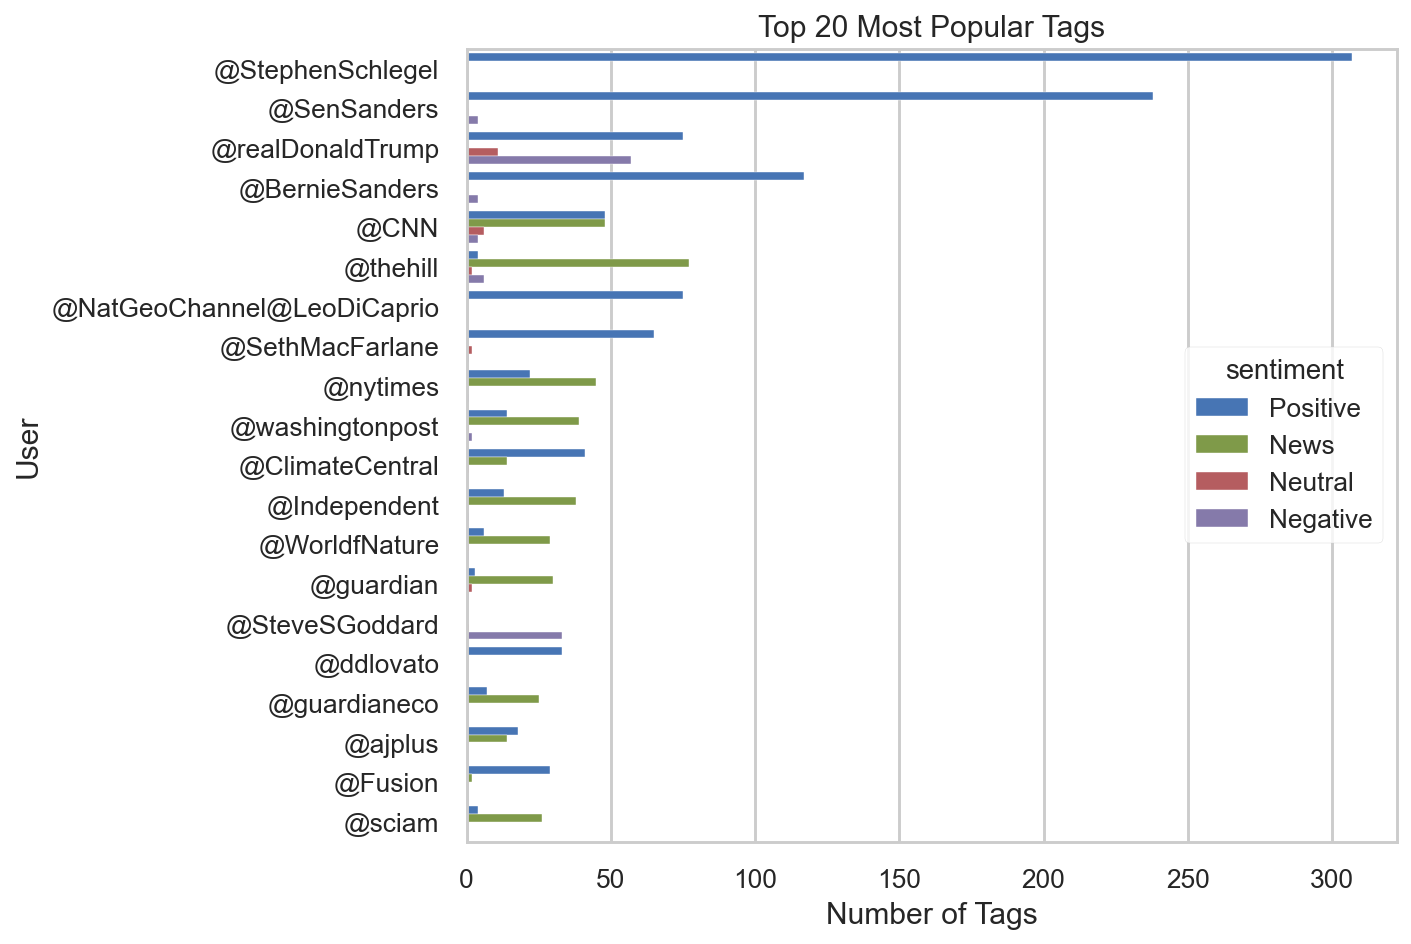

In [44]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(y="users", hue="sentiment", data=working_df,
              order=working_df.users.value_counts().iloc[:20].index) 

plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()
#plt.xticks(rotation=90)

In [10]:
# Combining all the messages
text = " ".join(tweet for tweet in train.message)
print ("There are {} words in the combination of all tweets.".format(len(text)))

There are 1973801 words in the combination of all tweets.


Word clouds are a simple visualization of data, in which words are shown in varying sizes depending on how often they appear. The kind of insight they provide even without much analysis being done helps in data normalization and in also what to expect as we dive deeper into data analysis. In our case, it is no surprise that both "climate change" and "global warming" as the biggest words in the could. Some other big words include "https" and "RT" which can be easily categorized as potential stopwords.

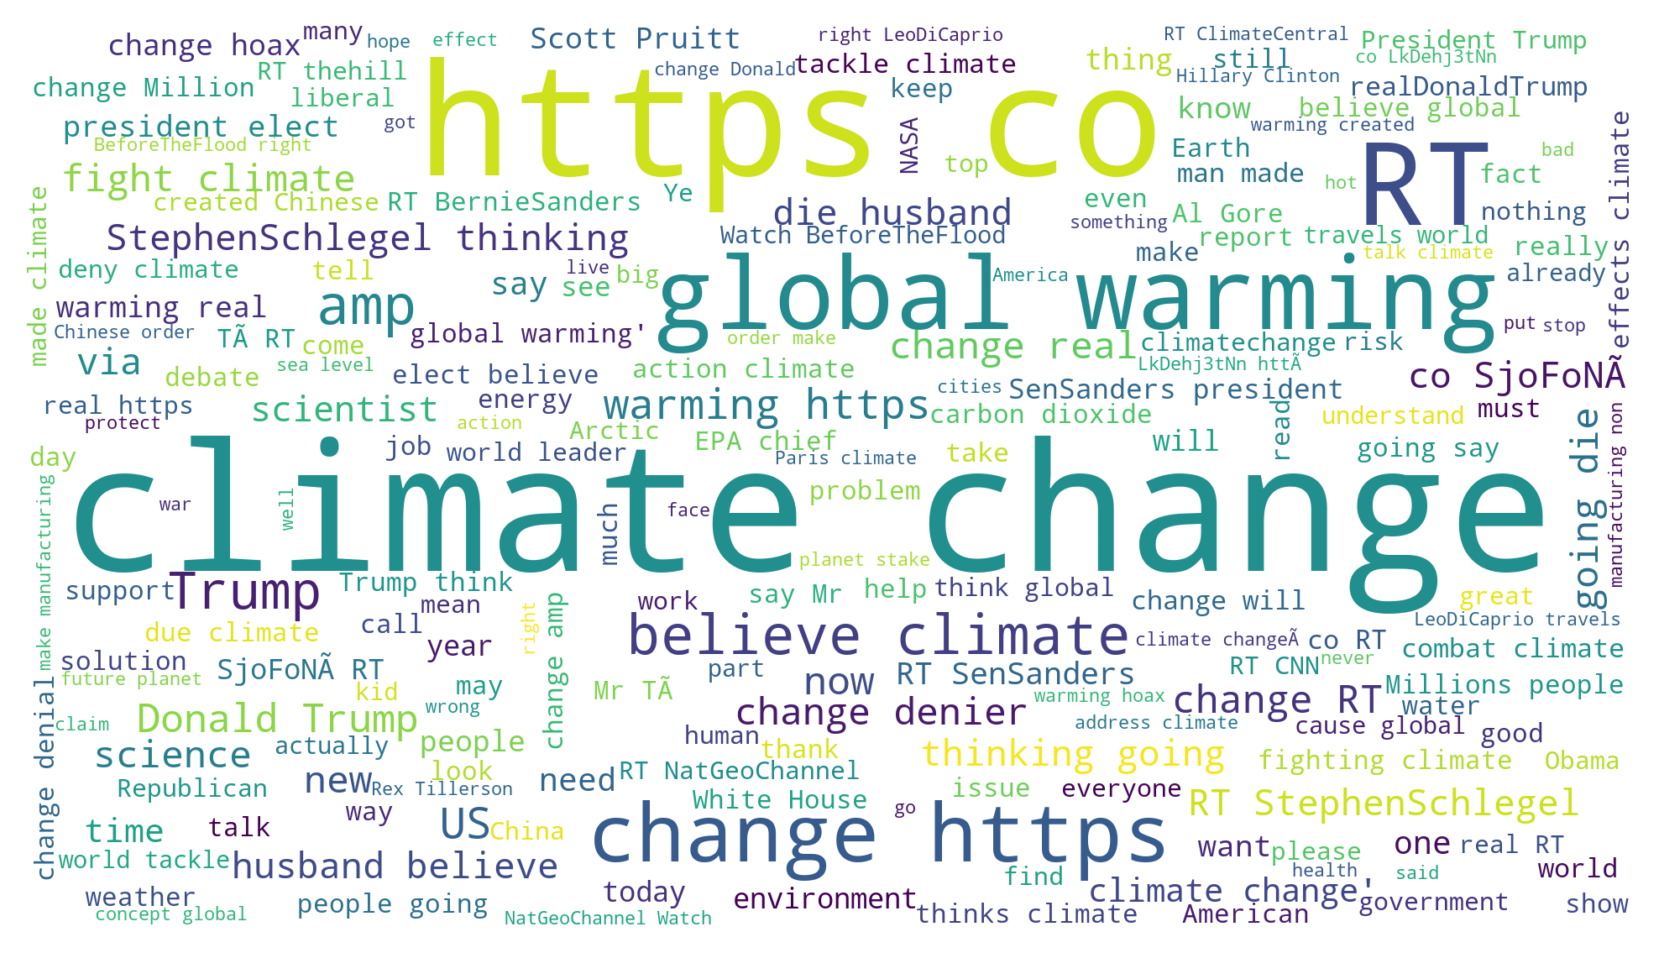

In [29]:
# Generating the word cloud image from all the messages
wordcloud = WordCloud(font_path='droidsansmono.ttf', background_color="white", width = 1920, height = 1080).generate(text)

# Displaying the word cloud image:
# using matplotlib way:
plt.figure(dpi=260)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data Cleaning

Database normalization is the process of structuring a relational database in accordance with a series of normal forms in order to reduce data redundancy. Applying it will aslo help improve data integrity as it entails organizing the attributes of a dataset to ensure that their dependencies are properly enforced by database integrity constraints.

Stemming and Lemmatization are Text Normalization techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.

A stemmer will return the stem of a word, which needn't be identical to the morphological root of the word. It usually sufficient that related words map to the same stem,even if the stem is not in itself a valid root, while in lemmatisation, it will return the dictionary form of a word, which must be a valid word.

In [12]:
# Testing the PorterStemmer 
stemmer = PorterStemmer()
print("The stemmed form of typing is: {}".format(stemmer.stem("typing")))
print("The stemmed form of types is: {}".format(stemmer.stem("types")))
print("The stemmed form of type is: {}".format(stemmer.stem("type")))

The stemmed form of typing is: type
The stemmed form of types is: type
The stemmed form of type is: type


In lemmatisation, the part of speech of a word should be first determined and the normalisation rules will be different for different part of speech, while the stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech.

In [13]:
# Testing Lemmatization
lemm = WordNetLemmatizer()
print("In  case of Lemmatization, typing is: {}".format(lemm.lemmatize("typing")))
print("In  case of Lemmatization, types is: {}".format(lemm.lemmatize("types")))
print("In  case of Lemmatization, type is: {}".format(lemm.lemmatize("type")))

In  case of Lemmatization, typing is: typing
In  case of Lemmatization, types is: type
In  case of Lemmatization, type is: type


The following function is an important step in the data mining process. In our case of classification, preprocessing data means; Data cleaning, Fill in missing values, smoothing noisy data and resolving any existing inconsistencies. Success in the steps will then make it possible and some-what easy for us to perform Data integration, Data transformation, Normalization and aggregation as well as Data reduction.

In [14]:
def data_preprocessor(df):
    '''
    For preprocessing we have cleaned the data, regularized it, transformed each cases, 
    tokenized the words from each setence/tweet and remove stopwords. For normalization, 
    we have used WordNetLemmatizer which transforms a sentence i.e. from this "love loving loved" 
    to this "love love love".
    
    '''
    stop_words = set(stopwords.words('english'))
    #stop_words.append(RT)
    #stemmer = PorterStemmer()
    lemm = WordNetLemmatizer()
    Tokenized_Doc=[]
    print("Preprocessing data.........\n")
    for data in df['message']:
        review = re.sub('[^a-zA-Z]', ' ', data)
        url = re.compile(r'https?://\S+|www\.\S+')
        review = url.sub(r'',review)
        html=re.compile(r'<.*?>')
        review = html.sub(r'',review)
        emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        review = emojis.sub(r'',review)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(review)
        #gen_tweets = [stemmer.stem(token) for token in tokens if not token in stop_words]
        gen_tweets = [lemm.lemmatize(token) for token in tokens if not token in stop_words]
        cleaned =' '.join(gen_tweets)
        Tokenized_Doc.append(gen_tweets)
        df['tweet tokens'] = pd.Series(Tokenized_Doc)
        #df.insert(loc=2, column='tweet tokens', value=Tokenized_Doc)
    return df

In [15]:
# crating a new and preprocessed dataframe: training
train_df = data_preprocessor(train)

Preprocessing data.........



In [16]:
# crating a new and preprocessed dataframe: testing
test_df = data_preprocessor(test)

Preprocessing data.........



In [17]:
# Defining the features as well as the labels
X = train_df['tweet tokens']
y = train_df['sentiment']

# Exploratory Data Analysis

# Feature Engineering and Selection

The term frequency-inverse document frequency (TF-IDF), is the tf-idf weight is a weight often used in information retrieval and text mining. Tf-idf can be successfully used for stop-words filtering in various subject fields including text summarization and classification.

In [18]:
data = X # train_df['tweet tokens']
corpus = [' '.join(i) for i in data] #create our corpus

vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.toarray())

', 'willfoth', 'willful', 'william', 'williamalley', 'williamhague', 'williamjordann', 'williamlegate', 'williamm', 'williams', 'williamsbudiman', 'williamson', 'willing', 'willis', 'willrworley', 'willtravers', 'wilmington', 'wilot', 'wilson', 'wilsonpark', 'wiltonpark', 'win', 'wind', 'windfall', 'windmill', 'windmills', 'window', 'windpower', 'wine', 'wines', 'winespectator', 'wing', 'wingsscotland', 'winktanner', 'winky', 'winlow', 'winner', 'winning', 'winstarvander', 'winter', 'wintergirl', 'winters', 'winwithoutwar', 'wioq', 'wiotgmsq', 'wipe', 'wiped', 'wiping', 'wiqfwzgmyd', 'wir', 'wire', 'wired', 'wireman', 'wirereporter', 'wiretapped', 'wiretapping', 'wiribgg', 'wiright', 'wirrow', 'wis', 'wiscindy', 'wisconsin', 'wisconson', 'wisdom', 'wisdomforwomen', 'wise', 'wisely', 'wish', 'wishing', 'wisteriajack', 'wit', 'witch', 'witchingbones', 'witchycleo', 'with', 'withdraw', 'withdrawal', 'withdrawing', 'withdraws', 'withdrew', 'withered', 'withering', 'witherspoon', 'withheld'

# Model Selection

### Up-sampling

### Changing the algorithm

# Model Evaluation

Accuracy is not always the best metric to use when evaluating imbalanced datasets as it can be very misleading. Metrics that can provide better insight include:

1. Confusion Matrix: table shows correct predictions and types of incorrect predictions.

In [19]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

NameError: name 'y_test' is not defined

2. Precision: the number of true positives divided by all positive predictions. 
3. Recall: the number of true positives divided by the number of positive values in the test data. 
4. F1: Score: the weighted average of precision and recall.

In [20]:
print(metrics.classification_report(y_test, y_pred))

NameError: name 'y_test' is not defined

# References